# Scalable K-means++ Re-implementation

#### Authors: J.C Lazzaro, Kangcheng Lin

#### Github link: https://github.com/Rykilla/STA663_SPRING2018_PROJECT.git

### Abstract

In *k-means* clustering, we are given a set of $n$ data points in d-dimensional space $\mathbb{R}^d$ and an integer $k$ and the problem is to determine a set of $k$ points in $\mathbb{R}^d$, called centers, so as to minimize the mean squared distance from each data point to its nearest center. One of the major issues of *k-means* algorithm is to find a good initialization for obtaining a good final solution. The paper, "Scalable k-means++"[1], introduces a new type of initialization *k-means||* as an improved version of an already existed initialization method *k-means++*, by taking advantage of parallel computing to resolve the issue of scalability in *k-means++* initialization due to its inherent sequential nature. In this final project, our group has managed to re-implement this paper using the techniques we have learnt in STA 663, and attempt optimization on plain python code using C++ and iPyParallel. Moreover, we have written a package, called *"sta663-jcl76"*, that contains some of our work.

**Key words**: *k-means, clustering, k-means++, k-means||, parallel computing, C++, iPyParallel*

## Content List

### 1. K-means Algorithm

> #### 1.1. Notation and background

> #### 1.2. Algorithms

>> #### 1.2.1. K-means++

>> #### 1.2.2. K-means++ Algorithm

>> #### 1.2.3. K-means||

>> #### 1.2.4. K-means|| Algorithm


### 2. Parallel Implementation

### 3. Re-implementation and Optimization (package installed here)

> #### 3.1. Optimization with C++

> #### 3.2. The Parallel Implementation using iPyParallel

### 4. Experiments

> #### 4.1. Experiment Setup

> #### 4.2. Datasets

> #### 4.3. Generate Datasets

> #### 4.4. Validating our Algorithm versus Existing Package

> #### 4.5. Comparison of initializations on Synthetic Data

>> #### 4.5.1. Comparing costs

>> #### 4.5.2. Comparing run time

> #### 4.6. Comparison of initializations on SPAM Data

>> #### 4.6.1. Comparing costs

>> #### 4.6.2. Comparing run time

### 5. A Brief note on the Parallel Version of K-means||

### 6. Summary

### 7. References

$$\text{}$$

## 1. K-means Algorithm

### 1.1. Notation and background

> Let $X=\{x_1,...,x_n \}$ be a set of points in the d-dimensional Euclidean space and let k be apositive integer specifying the number of clusters. Let $||x_i-x_j||$ denote the Eculidean distance between $x_i$ and $x_j$. For a point $x$ and a subset $Y \subseteq X$ of points, the distance is defined as $d(x,Y) = \text{min}_{y \in Y} ||x-y||$. For a subset $Y \subseteq X$ of points, lets is *centroid* be given by

$$\text{centroid}(Y) = \frac{1}{|Y|} \sum_{y \in Y}y$$

> Let $\mathcal{C} = \{c_1, ..., c_k \}$ be a set of points and let $Y \subseteq X$. We define the *cost* of Y with respect to $\mathcal{C}$ as 

$$\phi_Y(C)=\sum_{y\in Y} d^2(y,C) = \sum_{y \in Y} \min_{i=1,...,k}||y-c_i||^2$$

> The goal of *k-means* clustering is to choose a set $\mathcal{C}$ of $k$ centers to minimize $\phi_X(C)$.

### 1.2. Algorithms

#### 1.2.1. K-means++

The main idea in *k-means++* initialization algorithm is to choose the centers one by one in a controlled fashion, where the current set of chosen centers will stochastically *bias* the choice of the next center. The central drawback of *k-means++* initialization from a scalability point of view is its inherent *sequential* nature: the choice of the next center depends on the current set of centers.

#### 1.2.2. K-means++ Algorithm

> 1: $\mathcal{C} \leftarrow$ sample a point uniformly at random from $X$

> 2: **while** |$\mathcal{C}$| < $k$ **do**

>> 3: Sample $x \in X$ with probability $\frac{d^2(x,C)}{\phi_X(C)}$

>> 4: $\mathcal{C} \leftarrow C \bigcup \{x\}$

> 5: **end while**


#### 1.2.3. K-means||

The paper proposes an improved initialization method, called *k-means||*, which uses parallel computing to overcome the inherent *sequential* nature of *k-means++*. *k-means||* uses an *oversampling factor* $l=\Omega(k)$, such that the algorithm picks an inital center (uniformly at random) and computes $\psi$, the initial cost of the clustering after this selection. It then proceeds in $\log \psi$ iterations, where in each iteration, given the current set $\mathcal{C}$ of centers, it samples each x with probability $\frac{ld^2(x,C)}{\phi_X(C)}$. The sampled points are then added to $\mathcal{C}$, the quantity of $\phi_X(C)$ updated, and the iteration continued.

#### 1.2.4. K-means|| Algorithm

> 1: $\mathcal{C} \leftarrow$ sample a point uniformly at random from $X$

> 2: $\psi \leftarrow \Phi_X(C)$

> 3: **for** $O(\log\psi)$ **do**

>> 4: $\mathcal{C}^\prime \leftarrow$ sample each point $x\in X$ independently with probability $p_x=\frac{ld^2(x,C)}{\phi_X(C)}$

>> 5: $\mathcal{C} \leftarrow \mathcal{C} \bigcup \mathcal{C}^\prime$

> 6: **end for**

> 7: For $x \in \mathcal{C}$, set $w_x$ to be the number of points in $X$ closer to $x$ than any other point in $\mathcal{C}$

> 8: Recluster the weighted points in $\mathcal{C}$ into $k$ clusters.


## 2. A Parallel Implementation

> The paper also discusses a parallel implementation of *k-means||* in the MapReduce model of computation. Referring to the *k-means||* algorithm, we observe that Step 4 is very simple in MapReduce: each mapper can sample *independently* and Step 7 is equally simple given a set $\mathcal{C}$ of centers. Given a small set $\mathcal{C}$ of centers, computing $\phi_X(C)$ is also easy: each mapper working on an input partition $X^\prime \subseteq X$ can compute $\phi_{X^\prime}(C)$ and the reducer can simply add these values from all mapper to obtain $\phi_X(C)$. This takes care of Step 2 and the update to $\phi_X(C)$ neded for the iteration in Steps 3 to 6.

## 3. Re-implementation and Optimization

Our group has managed to re-implement both k-means++ initialization and k-means|| initialization methods. In order to achieve them, we have created 3 helper functions: distance function which returns a distance matrix between data points and chosen centroids; cost function which returns the cost given an input distance matrix; centroid weights function which compute the number of points choosing certain centroids, an essential part when reducing the oversampled centroids in k-means||. After writing all the algorithms, we put them in a package called "*sta663-jcl76*", which has been submitted to *Test Pypi*.

In [1]:
! pip install --user --index-url https://test.pypi.org/simple/ sta663-jcl76

Looking in indexes: https://test.pypi.org/simple/


In [2]:
from pkg.helper_func import cost, distance, centroid_weights
from pkg.kmeans_pp_init import k_means_pp
from pkg.kmeans_ll_init import K_Means_ll
from pkg.kmeans_func import k_means

With all the functions in package, we started optimizing them using either C++ or iPyParallel.

### 3.1. Optimization with C++

In [3]:
%%file k_means_wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>
#include <pybind11/stl.h>
#include <pybind11/cast.h>

Eigen::MatrixXd distance(Eigen::MatrixXd xs, Eigen::MatrixXd centroid, bool default_weight=true,
                         Eigen::VectorXd weights=Eigen::VectorXd::Ones(1))
{    
    /*
    Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    default_weight: a boolean value 0 and 1
    weights: ndarray of n dimensions(n)
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    */
    int n = xs.rows();
    int k = centroid.rows();
    int d = xs.cols();
    Eigen::MatrixXd distance_matrix(n,k);
    
    if (default_weight==true)
    {
        weights = Eigen::VectorXd::Ones(n);
    }
    
    for (int col_index=0; col_index<k; col_index++)
    {
        for (int row_index=0; row_index<n; row_index++)
        {
            double dist = (xs.row(row_index) - centroid.row(col_index)).norm();
            distance_matrix(row_index,col_index) = weights(row_index) * std::pow(dist,2);
        }
    }
    return distance_matrix;
}

double cost(Eigen::MatrixXd distance_matrix)
{
    /*
    Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    distance_matrix : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    cost: cost with respect to centroids
    */
    double cost;
    cost = distance_matrix.rowwise().minCoeff().sum();
    return cost;
}

Eigen::VectorXd centroid_weights(Eigen::MatrixXd distance_matrix)
{
    /*
    Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    distance_matrix : matrix of squared distances (nxk); likely returned from distance() function
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    */
    int n = distance_matrix.rows();
    int k = distance_matrix.cols();
    Eigen::MatrixXd weight_matrix(n,k);
    weight_matrix.fill(0);
    Eigen::VectorXd w_x(k);
    for (int row_index=0; row_index<n; row_index++)
    {
        double row_minimum_value = distance_matrix.row(row_index).minCoeff();
        for (int col_index=0; col_index<k; col_index++)
        {
            if (distance_matrix(row_index,col_index)==row_minimum_value)
            {
                weight_matrix(row_index,col_index)=1;
            }
        }
    }
    w_x = weight_matrix.colwise().sum();
    return w_x;
}

Eigen::MatrixXd k_means_pp(Eigen::MatrixXd xs, int k, int sd, bool verbose, Eigen::VectorXd weights)
{
    /*
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    */
    std::default_random_engine seed{sd}; // setting a seed
    
    int n = xs.rows();
    int d = xs.cols();
    int starting_index = rand() % n;
    Eigen::MatrixXd C = xs.row(starting_index);
    int loop = 0;
    
    while (C.rows() < k)
    {
        if ((loop % 10 == 0) & (verbose == true))
        {
            std::cout << "The current loop is: " << loop << std::endl;
        }
        Eigen::MatrixXd dist = distance(xs, C, true, Eigen::VectorXd::Ones(1));
        double cst = cost(dist);
        Eigen::VectorXd probs_x = dist.rowwise().minCoeff() / cst;
        std::default_random_engine generator;
        std::uniform_real_distribution<double> distribution(0.0,1.0);
        double random_number = distribution(generator);
        double sum_prob = 0;
        int index;
        for (int i=0; i<probs_x.size(); i++)
        {
            sum_prob += probs_x(i);
            if (sum_prob >= random_number)
            {
                index = i;
                break;
            }
        }
        Eigen::MatrixXd C_new = xs.row(index);
        Eigen::MatrixXd temp(C.rows()+C_new.rows(), C.cols());
        temp << C, C_new;        
        C = temp;
    }
    
    return C;
}

Eigen::MatrixXd k_means_parallel(Eigen::MatrixXd xs, int k, double l, int sd, int max_iter)
{
    /*
    Implements the K_means || algorithm
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    max_iter: an optional argument to seet the number of iterations
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    */
    int n = xs.rows();
    int d = xs.cols();
    int starting_index = rand() % n;
    int n_iter;
    Eigen::MatrixXd centroid = xs.row(starting_index);
    Eigen::MatrixXd dist = distance(xs, centroid, true, Eigen::VectorXd::Ones(1));
    double cost_init = cost(dist);
    int order = std::ceil(std::log10(cost_init));
    
    if (max_iter == 0)
    {
        n_iter = order;
    } else {
        n_iter = max_iter;
    }
    
    for (int i=0; i<n_iter; i++)
    {
        Eigen::MatrixXd distance_matrix = distance(xs, centroid, true, Eigen::VectorXd::Ones(1));
        double cst = cost(distance_matrix);
        Eigen::VectorXd probs_x = l * distance_matrix.rowwise().minCoeff() / cst;
        std::default_random_engine seed{sd}; // setting a seed
        for (int a=0; a<n; a++)
        {
            if (probs_x(a) > 1)
            {
                probs_x(a) = 1;
            }
            std::bernoulli_distribution distribution(probs_x(a));
            auto bern = std::bind(distribution, seed);
            if (bern())
            {
                Eigen::MatrixXd C_new = xs.row(a);
                Eigen::MatrixXd temp(centroid.rows()+1, d);
                temp << centroid, C_new;        
                centroid = temp;
            }
        }
    }
    
    Eigen::MatrixXd new_dist = distance(xs, centroid, true, Eigen::VectorXd::Ones(1));
    Eigen::VectorXd w_x = centroid_weights(new_dist);
    
    return k_means_pp(centroid, k, sd, false, w_x);
}

Eigen::MatrixXd k_means(Eigen::MatrixXd X, int k, Eigen::MatrixXd centroids)
{
    /*
    This function will separate X into k clusters
    using the classic k-means algorithm.
    
    Parameters:
    -----------
    X : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    centroids: ndarray of initial centroids (kxd)
    verbose: an optional argument to show progress of algorithm

    Returns:
    --------
    Centroids: k centers after clustering
    Cluster_Indices: cluster classification for each data point
    Number of Iterations: number of iterations until convergence
    Total Cost: cost after convergence
    */
    int max_iter = 1000;
    int step = 0;
    int n = X.rows();
    
    while (step < max_iter)
    {
        Eigen::MatrixXd distance_matrix = distance(X, centroids, true, Eigen::VectorXd::Ones(1));
        Eigen::MatrixXd weight_matrix(n,k);
        weight_matrix.fill(0);
        for (int row_index=0; row_index<n; row_index++)
        {
            double row_minimum_value = distance_matrix.row(row_index).minCoeff();
            for (int col_index=0; col_index<k; col_index++)
            {
                if (distance_matrix(row_index,col_index)==row_minimum_value)
                {
                    weight_matrix(row_index,col_index)=1;
                }
            }
        }
        
        Eigen::MatrixXd update_centroids(centroids.rows(), centroids.cols());
        Eigen::VectorXd count = weight_matrix.colwise().sum();
        for (int c=0; c<k; c++)
        {
            update_centroids.row(c) = X.transpose()*weight_matrix.col(c) / count(c);
        }
        
        if (centroids == update_centroids)
        {
            return centroids;
        } else {
            centroids = update_centroids;
            step += 1;
        }
        
    }
    return centroids;
}

PYBIND11_MODULE(k_means_wrap, m) {
    m.doc() = "helpers functions for k-means|| initialization";
    m.def("distance", &distance, "distance matrix function");
    m.def("cost", &cost, "cost function");
    m.def("centroid_weights", &centroid_weights, "distance matrix function");
    m.def("k_means_pp", &k_means_pp, "k-means++ algorithm");
    m.def("k_means_parallel", &k_means_parallel, "k-means|| algorithm");
    m.def("k_means", &k_means, "k-means algorithm");
}

Overwriting k_means_wrap.cpp


### 3.2. The Parallel Implementation using iPyParallel

In [4]:
from ipyparallel import Client

rc = Client()
dv = rc[:]
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
@dv.parallel(block=True)
def distance_ll(x):
    '''Computes matrix of squared distance from each point to each centroid in parallel.
    
    Parameters:
    -----------
    x: ndarray of n points in d dimensional Euclidean space (nxd)
    
    Returns:
    --------
    dist: matrix of squared distances (nxk)
    '''
    import numpy
    dist = numpy.sum((x[:,None,:] - centroid)**2, axis=-1)
    return dist


@dv.parallel(block=True)
def cost_ll(dist):
    """Computes the cost of a set of points with respect to a collection of centroids in parallel.
    
    Parameters:
    -----------
    dist: matrix of squared distances (nxk) returned from distance_ll() function
    
    Returns:
    --------
    cost: ndarray of cost with respect to centroids on each partition
    """
    import numpy
    min_dist = numpy.min(dist, axis=1)
    cost = numpy.sum(min_dist)
    return cost

@dv.parallel(block=True)
def sample_cent(dist):
    """Samples new centroids for k-means_ll initialization in parallel.
    
    Parameters:
    -----------
    dist: matrix of squared distances (nxk) returned from distance_ll() function
    
    Returns:
    --------
    idx: ndarray of indices indicating points sampled as new centroids
    """
    import numpy
    numpy.random.seed(sd)
    min_dist = numpy.min(dist, axis=1)
    
    prob_x = l*min_dist/cost
    if any(prob_x>1):
        prob_x[numpy.where(prob_x>1)] = 1
    
    idx = numpy.random.binomial(1, p = prob_x)
    return idx

@dv.parallel(block=True)
def weights_ll(dist):
    """Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    dist: matrix of squared distances (nxk) returned from distance_ll() function
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    """
    import numpy
    c_close = numpy.zeros(dist.shape)
    c_close[numpy.arange(dist.shape[0]), numpy.argmin(dist, axis = 1)] = 1
    
    return c_close

In [6]:
from kmeans_pp_init import k_means_pp

def K_Means_ll_ipy(xs, k, l, seed=None, max_iter=None):
    """Implements the K_means || algorithm using parallel intermediary functions
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    max_iter: an optional argument to seet the number of iterations
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    dv.push(dict(centroid=centroid, l=l, sd=seed))
    
    cost_int = np.sum(cost_ll(distance_ll(xs)))
    order = np.log10(cost_int)
    
    if max_iter is not None:
        n_iter = max_iter
    else:
        n_iter = np.round(order)
    
    for i in np.arange(n_iter):
        
        dist = distance_ll(xs)
        cost = np.sum(cost_ll(dist))
        dv.push(dict(cost=cost))
        centroid_new = xs[sample_cent(dist) == 1,:]
        
        centroid = np.vstack((centroid,centroid_new))
        dv.push(dict(centroid=centroid))
    
    w_x = np.sum(weights_ll(distance_ll(xs)),axis=0)
    
    #Implement k-means++ to recluster weighted points in C
    C = k_means_pp(centroid,k,seed=seed,weights=w_x)
    return C

## 4. Experiments

### 4.1. Experiment Setup

It is noted that this paper was published in 2012, and we are re-implementing it in 2018. According to the paper, they used a single workstation with quad-core 2.5GHz processors and 16Gb of memory. The parallel algorithms were run using a Hadoop cluster of 1968 nodes, each with two quad-core 2.5GHz processors and 16GB of memory. On the other hand, we are using Duke Virtual Machine to carry out the experiments. The difference in specs may result in different performance.

### 4.2. Datasets

We are using the same datasets used by the original paper; namely, one synthetic dataset *GAUSSMIXTURE*; one real-life dataset, *SPAM*[2], from UC Irvine Machine Learning repository (archive.ics.uci.edu/ml/datasets.html).

To generate the synthetic *GAUSSMIXTUE* dataset, we sampled $k$ centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R \in \{1,10,100\}$. We then added points from Gaussian distribution of unit ariance around each center. Given the k centers, this is a mixture of $k$ spherical Gaussians with equal weights. Note that the Gaussians are separated in terms of probability mass, and thus the value of the optimal k-clustering can be approximated using the centers of these Gausians. The number of smapled points from this mixture of Gaussians is $n=10,000$.

On the other hand, the real-life dataset *SPAM* consists of 4601 points in 58 dimensions and represents features available to an e-mail spam detection system.

### 4.3. Generate Datasets

In [7]:
%matplotlib inline

In [8]:
import numpy as np
from sklearn.datasets import make_blobs 

def GaussMix(R, k, n=10000, d=15, seed=None):
    """Generates GaussMixture synthetic dataset"""
    np.random.seed(seed)
    mu = np.zeros(d)
    sigma = np.diag(R*np.ones(d))
    centers = np.random.multivariate_normal(mean=mu, cov=sigma, size=k)
    
    X,y = make_blobs(n_samples=n, n_features=d, centers=centers, random_state=seed)
    return X,y

A pairs plot of the first five dimensions of this dataset is given below:



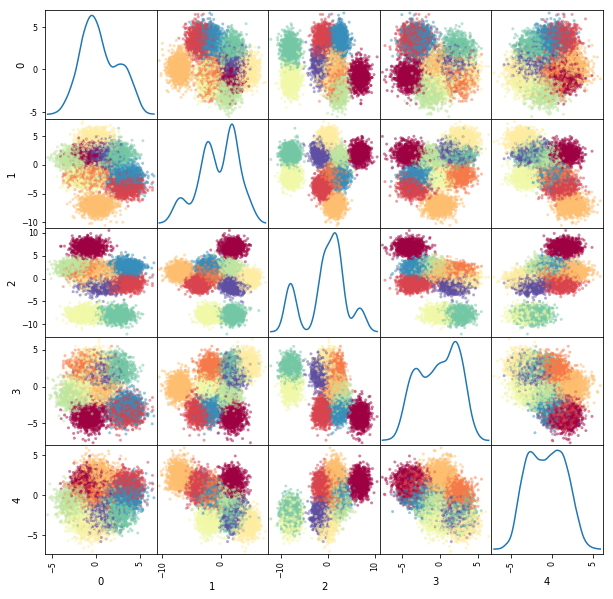

In [9]:
import pandas as pd

seed = 2018
k=10
GM = GaussMix(10,k,seed=seed)
df = pd.DataFrame(GM[0])
y = GM[1]
pd.plotting.scatter_matrix(df.iloc[:,0:5], c=y, figsize=(10,10),
                           diagonal='kde', alpha=0.5, cmap='Spectral')
pass

### 4.4. Validating our Algorithm versus Existing Package

Prior to proceeding with more in depth analysis, we validate that our K-Means function produces analogous results to an existing algorithm from scikit-learn. We do so by graphically displaying the relationship between the first and second dimension of the GaussMixture dataset after clustering and comparing the final costs of each algorithm.

In [10]:
from sklearn.cluster import KMeans
from kmeans_func import k_means

xs = GM[0]
np.random.seed(seed)
c_int_r = xs[np.random.choice(xs.shape[0],k,replace=False),:]

pred_r = k_means(xs,k,c_int_r)
plib = KMeans(k,init='random',random_state=seed,n_init=1).fit(xs)

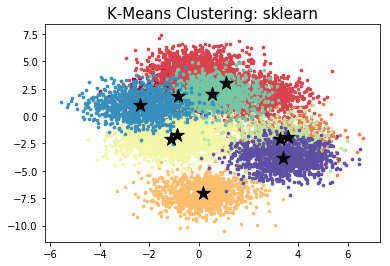

In [11]:
import matplotlib.pyplot as plt

colors = plt.cm.Spectral(np.linspace(0,1,k))
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([xs[j,0:2] for j in range(xs.shape[0]) if plib.labels_[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(plib.cluster_centers_[:,0], plib.cluster_centers_[:,1], marker='*', s=200, c='black')
plt.title('K-Means Clustering: sklearn', fontsize=15)
pass

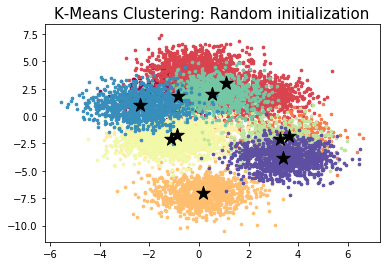

In [12]:
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([xs[j,0:2] for j in range(xs.shape[0]) if pred_r['Cluster Indices'][j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(pred_r['Centroids'][:,0], pred_r['Centroids'][:,1], marker='*', s=200, c='black')
plt.title('K-Means Clustering: Random initialization', fontsize=15)
pass

In [13]:
from helper_func import distance, cost

l_error = np.sum(plib.labels_==pred_r['Cluster Indices'])/len(plib.labels_)

print('Percent of points with same classification:', l_error)
print('Final cost using sklearn:',cost(distance(xs,plib.cluster_centers_)))
print('Final cost using our algorithm:',cost(distance(xs,pred_r['Centroids'])))

Percent of points with same classification: 0.9948
Final cost using sklearn: 206225.291280148
Final cost using our algorithm: 206216.46554543136


For completeness, we also include the same plots for the k-means++ and k-means|| initializations along with the final cost as a preliminary comparison before proceeding to a more robust validation on this synthetic dataset as described in Section 5 of the original paper.

Final cost using k-means++ initialization: 206144.228558799


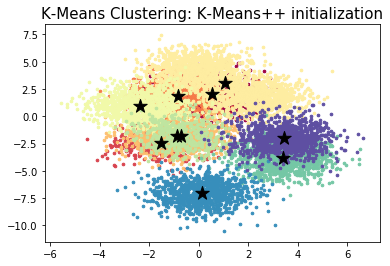

In [14]:
from kmeans_pp_init import k_means_pp

c_int_pp = k_means_pp(xs, 10, seed=seed)
pred_pp = k_means(xs,k,c_int_pp)

fig, ax = plt.subplots()
for i in range(k):
        points = np.array([xs[j,0:2] for j in range(xs.shape[0]) if pred_pp['Cluster Indices'][j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(pred_pp['Centroids'][:,0], pred_pp['Centroids'][:,1], marker='*', s=200, c='black')
plt.title('K-Means Clustering: K-Means++ initialization', fontsize=15)
pass

print('Final cost using k-means++ initialization:',cost(distance(xs,pred_pp['Centroids'])))

Final cost using k-means|| initialization with l=10, r=5: 199872.03497686313


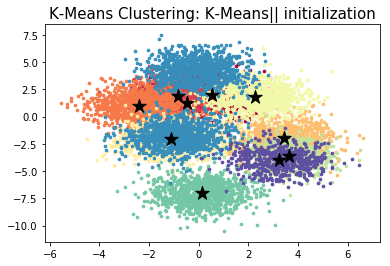

In [15]:
from kmeans_ll_init import K_Means_ll

c_int_ll = K_Means_ll(xs, 10, l=10, seed=seed, max_iter=5)
pred_ll = k_means(xs,k,c_int_ll)

fig, ax = plt.subplots()
for i in range(k):
        points = np.array([xs[j,0:2] for j in range(xs.shape[0]) if pred_ll['Cluster Indices'][j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(pred_ll['Centroids'][:,0], pred_ll['Centroids'][:,1], marker='*', s=200, c='black')
plt.title('K-Means Clustering: K-Means|| initialization', fontsize=15)
pass

print('Final cost using k-means|| initialization with l=10, r=5:',cost(distance(xs,pred_ll['Centroids'])))

### 4.5. Comparison of initializations on Synthetic Data

In this section we compare the three initializations to the K-Means algorithm: random, k-means++, and k-means||, on the GaussMixture dataset for various values of $R$ - the variance of the spherical Gaussian distribution. We replicate the results of Table 1 of Bahamani et al using only the raw Python functions, and compare the run times of the various initializations also using the optimized and parallelized versions of the various algorithms.

In [16]:
def cost_validation(data,k,scale,r_1=5,r_2=5,seed=2018, rand_init = True, k_pp = True):
    
    if rand_init == True:
        np.random.seed(seed)
        c_init_r = data[np.random.choice(data.shape[0],k,replace=False),:]
        k_out_r = k_means(data,k,centroids=c_init_r)
        print('Scaled final cost for random initialization:', k_out_r['Total Cost']/scale)
        
    if k_pp == True:
        c_init_pp = k_means_pp(data, k, seed=seed)
        k_out_pp = k_means(data,k,centroids=c_init_pp)
        print('Scaled final cost for k-means++ initialization:', k_out_pp['Total Cost']/scale)
        
    c_init_ll_1 = K_Means_ll(data, k, l=k/2, seed=seed, max_iter=r_1)
    c_init_ll_2 = K_Means_ll(data, k, l=k, seed=seed, max_iter=r_2)
    
    k_out_ll_1 = k_means(data,k,centroids=c_init_ll_1)
    print('Scaled final cost for k-means|| initialization with l=',k/2,
          'and r=',r_1,':', k_out_ll_1['Total Cost']/scale)
    
    k_out_ll_2 = k_means(data,k,centroids=c_init_ll_2)
    print('Scaled final cost for k-means|| initialization with l=',k,
          'and r=',r_2,':', k_out_ll_2['Total Cost']/scale)

#### 4.5.1. Comparing Costs

In [17]:
k = 50
R = 1
s_data, s_true_labels = GaussMix(R,k,seed=seed)
cost_validation(s_data,k,seed=seed,scale=10**4)

Scaled final cost for random initialization: 14.445285950793771
Scaled final cost for k-means++ initialization: 14.3433669325239
Scaled final cost for k-means|| initialization with l= 25.0 and r= 5 : 14.392225450619707
Scaled final cost for k-means|| initialization with l= 50 and r= 5 : 14.459506208886788


In [18]:
k = 50
R = 10
s_data, s_true_labels = GaussMix(R,k,seed=seed)
cost_validation(s_data,k,seed=seed,scale=10**4)

Scaled final cost for random initialization: 23.574261552769048
Scaled final cost for k-means++ initialization: 19.381989598231385
Scaled final cost for k-means|| initialization with l= 25.0 and r= 5 : 19.593586729181308
Scaled final cost for k-means|| initialization with l= 50 and r= 5 : 21.063295959642634


In [19]:
k = 50
R = 100
s_data, s_true_labels = GaussMix(R,k,seed=seed)
cost_validation(s_data,k,seed=seed,scale=10**4)

Scaled final cost for random initialization: 195.15793834571036
Scaled final cost for k-means++ initialization: 32.58898986150759
Scaled final cost for k-means|| initialization with l= 25.0 and r= 5 : 64.6133002341078
Scaled final cost for k-means|| initialization with l= 50 and r= 5 : 26.569447788344057


#### 4.5.2. Comparing Run Time

In [20]:
import cppimport
cppimport.force_rebuild()
k_means_wrap = cppimport.imp("k_means_wrap")

In [21]:
seed = 2018
np.random.seed(seed)
k=50
data,labels = GaussMix(10,k,seed=seed)

#### Using Raw Python Functions

In [22]:
%%time
init = data[np.random.choice(data.shape[0],k,replace=False),:]
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 19 iterations
CPU times: user 1.18 s, sys: 2.47 s, total: 3.65 s
Wall time: 3.65 s


In [23]:
%%time
init = k_means_pp(data, k, seed=seed)
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 28 iterations
CPU times: user 2.91 s, sys: 5.47 s, total: 8.38 s
Wall time: 8.39 s


In [24]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 15 iterations
CPU times: user 1.69 s, sys: 3 s, total: 4.69 s
Wall time: 4.69 s


In [25]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 12 iterations
CPU times: user 1.84 s, sys: 1.43 s, total: 3.27 s
Wall time: 3.49 s


#### Using Wrapped C++ Functions

In [26]:
%%time
init = data[np.random.choice(data.shape[0],k,replace=False),:]
final = k_means_wrap.k_means(data, k, init)

CPU times: user 324 ms, sys: 4 ms, total: 328 ms
Wall time: 323 ms


In [27]:
%%time
#init = k_means_wrap.k_means_pp(data, k, seed, True, np.array([1]))
init = k_means_pp(data, k, seed=seed)
final = k_means_wrap.k_means(data, k, init)

CPU times: user 1.62 s, sys: 1.57 s, total: 3.2 s
Wall time: 3.19 s


In [28]:
%%time
#init = k_means_wrap.k_means_parallel(data, k, k, seed, 5)
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)
final = k_means_wrap.k_means(data, k, init)

CPU times: user 996 ms, sys: 1.24 s, total: 2.24 s
Wall time: 2.24 s


In [29]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)
final = k_means_wrap.k_means(data, k, init)

CPU times: user 1.15 s, sys: 152 ms, total: 1.3 s
Wall time: 1.5 s


### 4.6. Comparison of initializations on SPAM Data

#### 4.6.1. Comparing Costs

In [30]:
seed = 2018
np.random.seed(seed)
k=20

spam = pd.read_table("./spam_data/spambase.data", sep=",", header=None)
spam_data = spam.iloc[:,0:57]
spam_true_labels = spam.iloc[:,57]
data = spam_data.values

In [31]:
cost_validation(data,k=20,seed=seed,scale=10**5)

Scaled final cost for random initialization: 1527.9910802441161
Scaled final cost for k-means++ initialization: 253.1563730823114
Scaled final cost for k-means|| initialization with l= 10.0 and r= 5 : 263.9683878437664
Scaled final cost for k-means|| initialization with l= 20 and r= 5 : 318.2286497513889


In [32]:
cost_validation(data,k=50,seed=seed,scale=10**5)

Scaled final cost for random initialization: 1497.0325110581941
Scaled final cost for k-means++ initialization: 66.68003698723575
Scaled final cost for k-means|| initialization with l= 25.0 and r= 5 : 66.04297973030027
Scaled final cost for k-means|| initialization with l= 50 and r= 5 : 67.1901949191221


In [33]:
cost_validation(data,k=100,seed=seed,scale=10**5)

Scaled final cost for random initialization: 1392.3041408294398
Scaled final cost for k-means++ initialization: 24.044566238447594
Scaled final cost for k-means|| initialization with l= 50.0 and r= 5 : 24.50796324677153
Scaled final cost for k-means|| initialization with l= 100 and r= 5 : 24.313883461510617


#### 4.6.2. Comparing Run Time

#### Using Raw Python Functions

In [34]:
%%time
init = data[np.random.choice(data.shape[0],k,replace=False),:]
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 146 iterations
CPU times: user 3.74 s, sys: 8 ms, total: 3.75 s
Wall time: 3.76 s


In [35]:
%%time
init = k_means_pp(data, k, seed=seed)
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 21 iterations
CPU times: user 776 ms, sys: 4 ms, total: 780 ms
Wall time: 778 ms


In [36]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 14 iterations
CPU times: user 760 ms, sys: 476 ms, total: 1.24 s
Wall time: 1.24 s


In [37]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')

Convergence after 8 iterations
CPU times: user 1.27 s, sys: 144 ms, total: 1.42 s
Wall time: 1.54 s


#### Using Wrapped C++ Functions

In [38]:
%%time
init = data[np.random.choice(data.shape[0],k,replace=False),:]
final = k_means_wrap.k_means(data, k, init)

CPU times: user 1.79 s, sys: 28 ms, total: 1.82 s
Wall time: 1.83 s


In [39]:
%%time
#init = k_means_wrap.k_means_pp(data, k, seed, True, np.array([1]))
init = k_means_pp(data, k, seed=seed)
final = k_means_wrap.k_means(data, k, init)

CPU times: user 464 ms, sys: 0 ns, total: 464 ms
Wall time: 461 ms


In [40]:
%%time
#init = k_means_wrap.k_means_parallel(data, k, k, seed, 5)
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)
final = k_means_wrap.k_means(data, k, init)

CPU times: user 524 ms, sys: 488 ms, total: 1.01 s
Wall time: 1.01 s


In [41]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)
final = k_means_wrap.k_means(data, k, init)

CPU times: user 964 ms, sys: 120 ms, total: 1.08 s
Wall time: 1.34 s


## 5. A Brief note on the Parallel Version of K-means||

We note that the vectorized k-means|| initialization runs more efficiently than the block parallel version on both the synthetic and real dataset. However, this result changes if we increase the number of centers, features, and observations of the dataset under consideration. To demonstrate this, we will alter the parameters of the synthetic GaussMixture dataset and compare the relative changes in run time for both methods.

We first use the unaltered GaussMixture dataset used for validation as a benchmark.

In [42]:
seed = 2018
k=10
data,labels = GaussMix(10,k,seed=seed)

In [43]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 160 ms, sys: 20 ms, total: 180 ms
Wall time: 157 ms


In [44]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 772 ms, sys: 104 ms, total: 876 ms
Wall time: 1.01 s


We see that moderate increases in the size of the dataset, other things equal, causes the vectorized version to become appreciably slower while the parallelized version shows no marked change in run time.

As an aside, we note that the outputs of these two versions of the k-means|| initialization vary. This is corroborated by the fact that the final costs of the k-means algorithm vary for each initialization.

The discrepancy between these two functions is likely due to the difference regarding how each version samples new centroids during each iteration. The vectorized version samples from the entire dataset simultaneously, while the parallel version samples from each partition. Hence, give that the seed is set on each partition, the results of the parallel version are not likely to conform with that of the vectorized version.

In [45]:
k=10
data,labels = GaussMix(10,k,n=100000,seed=seed)

In [46]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 1.79 s, sys: 2.85 s, total: 4.64 s
Wall time: 4.66 s


In [47]:
%%time
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')
print('Scaled final cost using vectorized k-means||',cost(distance(data,final['Centroids']))/10**4)

Convergence after 57 iterations
Scaled final cost using vectorized k-means|| 211.0663579719908
CPU times: user 6.43 s, sys: 3.06 s, total: 9.49 s
Wall time: 9.57 s


In [48]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 1.17 s, sys: 440 ms, total: 1.61 s
Wall time: 2.88 s


In [49]:
%%time
final = k_means(data,k,centroids=init)
print('Convergence after',final['Number of Iterations'],'iterations')
print('Scaled final cost using parallel k-means||',cost(distance(data,final['Centroids']))/10**4)

Convergence after 51 iterations
Scaled final cost using parallel k-means|| 202.63317011461362
CPU times: user 6.04 s, sys: 7.89 s, total: 13.9 s
Wall time: 14 s


Moreover, as the number of observations in the dataset grows larger, the relative efficiency of the parallel implementation of k-means|| becomes more apparent, as shown below:

In [50]:
k=10
data,labels = GaussMix(10,k,n=400000,seed=seed)

In [51]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 5.2 s, sys: 26.1 s, total: 31.3 s
Wall time: 31.4 s


In [52]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 1.18 s, sys: 1.37 s, total: 2.55 s
Wall time: 4.86 s


Increasing the number of desired centers, in conjunction with a sligt increase in the size of the dataset, also results in the parallel implementation becoming more efficient than the vectorized version.

In [53]:
k=50
data,labels = GaussMix(10,k,n=50000,seed=seed)

In [54]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 3.74 s, sys: 7.81 s, total: 11.5 s
Wall time: 11.6 s


In [55]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 1.09 s, sys: 428 ms, total: 1.52 s
Wall time: 2.66 s


Moreover, the same phenomenon can be observed by increasing the number of feature in the dataset.

In [56]:
k=10
data,labels = GaussMix(10,k,n=100000,d=30,seed=seed)

In [57]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 3.3 s, sys: 6.69 s, total: 9.99 s
Wall time: 10 s


In [58]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 1.06 s, sys: 408 ms, total: 1.46 s
Wall time: 3.31 s


Lastly, we note that increasing the number of centers in conjunction with the number of features seems to produce the most marked improvement in the parallel version relative to the vectorized version, even with a relatively small number of observations.

In [59]:
k=35
data,labels = GaussMix(10,k,n=50000,d=30,seed=seed)

In [60]:
%%time
init = K_Means_ll(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 3.78 s, sys: 9.09 s, total: 12.9 s
Wall time: 13 s


In [61]:
%%time
init = K_Means_ll_ipy(data, k, l=k, seed=seed, max_iter=5)

CPU times: user 1.15 s, sys: 444 ms, total: 1.6 s
Wall time: 3.33 s


## 6. Summary

In this project, we re-implemented k-means++ and k-means|| initialization methods, and optimized them using C++ and iPyparallel. Moreover, we validated our results by comparing them with those generated by existing packages. We also compared the cost and run time across different methods. At last, we also made a brief comparison between vectorized k-means|| and block parallel k-means|| on both synthetic and real-life datasets.

It is noted that the original paper carried out the implementation in Hadoop, which is an open-source software framework for storing data and running applications on clusters of commodity hardware. This provided them the capability to run their experiments on a much bigger dataset, called KDDCup1999[3], which contained more than 4.8 million datapoints with 42 features. Due to time constraint and techinical difficulty, we were unable to fully explore this dataset using Spark. Therefore, one of the future works could involve an implementation of k-means++ and k-means|| on Spark, so that they may take full advantage of partition and parallelization.

## 7. References

[1]. Bahmani, B., Moseley, B., Vattani, A., Kumar, R., & Vassilvitskii, S. (2012). Scalable K-means.

[2]. Hopkins, M. (1999, July 1). Spambase Data Set. Retrieved April 26, 2018, from https://archive.ics.uci.edu/ml/datasets/spambase

[3]. KDD Cup 1999 Data Data Set. (1999, January 1). Retrieved April 26, 2018, from http://archive.ics.uci.edu/ml/datasets/kdd+cup+1999+data